In [1]:
import os

In [11]:
data_dir = "/home/bartu/Downloads/cell_images"

In [12]:
os.listdir(data_dir)

['train', 'test']

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
from matplotlib.image import imread

In [16]:
test_path = data_dir + "/test/"
os.listdir(test_path)
train_path = data_dir + "/train/"
os.listdir(train_path)

['uninfected', 'parasitized']

### Investigate the image sizes to decide the resizing size.

In [20]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path + "uninfected"):
    
    img = imread(test_path + "uninfected/" + image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

/home/bartu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


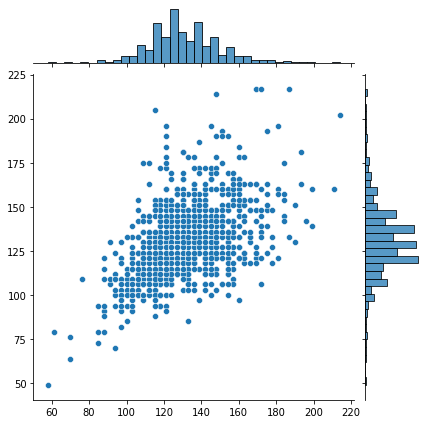

In [21]:
sns.jointplot(dim1, dim2)

In [22]:
np.mean(dim1)

130.92538461538462

In [23]:
np.mean(dim2)

130.75

In [24]:
image_shape = (130, 130, 3)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
image_gen = ImageDataGenerator(rotation_range = 20,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = "nearest")

In [27]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [28]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

In [31]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = image_shape, activation = "relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = image_shape, activation = "relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = image_shape, activation = "relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(monitor = "val_loss", patience = 2)

In [35]:
batch_size = 32

In [36]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size = image_shape[:2],
                                                color_mode = "rgb",
                                                batch_size = batch_size,
                                                class_mode = "binary")

Found 24958 images belonging to 2 classes.


In [37]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size = image_shape[:2],
                                                color_mode = "rgb",
                                                batch_size = batch_size,
                                                class_mode = "binary",
                                                shuffle = False)

Found 2600 images belonging to 2 classes.


In [38]:
results = model.fit_generator(train_image_gen, epochs = 20, validation_data = test_image_gen, callbacks = [early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
780/780 [==============================] - 210s 269ms/step - loss: 0.4639 - accuracy: 0.8778 - val_loss: 0.2242 - val_accuracy: 0.9181
Epoch 2/20
780/780 [==============================] - 200s 256ms/step - loss: 0.2195 - accuracy: 0.9283 - val_loss: 0.2195 - val_accuracy: 0.9265
Epoch 3/20
780/780 [==============================] - 205s 263ms/step - loss: 0.2277 - accuracy: 0.9255 - val_loss: 0.2344 - val_accuracy: 0.9200
Epoch 4/20
780/780 [==============================] - 229s 293ms/step - loss: 0.2154 - accuracy: 0.9303 - val_loss: 0.2079 - val_accuracy: 0.9304
Epoch 5/20
780/780 [==============================] - 226s 289ms/step - loss: 0.1995 - accuracy: 0.9371 - val_loss: 0.1925 - val_accuracy: 0.9304
Epoch 6/20
780/780 [==============================] - 226s 290ms/step - loss: 0.1847 - accuracy: 0.9427 - val_loss: 0.1816 - val_accuracy: 0.9427
Epoch 7/20
780/780 [============================

In [41]:
model.metrics_names
model.evaluate(test_image_gen)

82/82 [==============================] - 12s 141ms/step - loss: 0.1570 - accuracy: 0.9454


[0.15699678659439087, 0.9453846216201782]

In [44]:
pred = model.predict(test_image_gen)

In [46]:
predictions = pred > 0.5

In [47]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [50]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1300
           1       0.94      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [51]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1215,   85],
       [  45, 1255]])